# Week 13 - Day 1: Feedforward Neural Networks for Trading

## Introduction to Neural Networks in Quantitative Finance

Welcome to the neural networks module! This marks a significant milestone in your quantitative finance journey—moving from classical machine learning to deep learning approaches that power many modern systematic trading strategies.

### Why Neural Networks Matter in Quant Finance

Neural networks have become indispensable tools at leading quantitative firms for several reasons:

1. **Non-linear Pattern Recognition**: Financial markets exhibit complex, non-linear relationships that traditional linear models often miss. Neural networks can capture intricate dependencies between features.

2. **Feature Learning**: Unlike classical ML where feature engineering is manual, neural networks can automatically learn hierarchical representations from raw data.

3. **Scalability**: Modern architectures can process vast amounts of alternative data—from satellite imagery to social media sentiment—that would be impossible to handle with traditional methods.

4. **Adaptive Modeling**: Neural networks can adapt to changing market regimes through continuous retraining, crucial for dynamic markets like the **European equity markets** (STOXX 600, DAX, CAC 40) which exhibit different volatility patterns than US markets.

### Target Audience

This notebook is designed for aspiring quantitative traders targeting **European markets**. We'll use US equity data (SPY) for demonstration due to data availability, but the techniques apply directly to European indices and individual equities. European traders should note:

- Different trading hours (08:00-16:30 CET for most European exchanges)
- Higher sensitivity to ECB monetary policy announcements
- Cross-border regulatory considerations (MiFID II)
- Currency considerations when trading non-EUR denominated assets

### What You'll Learn Today

1. Core neural network theory (perceptrons, activation functions, forward propagation)
2. Building a Multi-Layer Perceptron (MLP) using PyTorch
3. Feature engineering for price prediction
4. Training, validation, and backtesting workflows
5. Performance evaluation with industry-standard metrics

---

## 1. Environment Setup

We'll use PyTorch as our deep learning framework. PyTorch is preferred at many quant firms (Two Sigma, Citadel) for its:
- Dynamic computational graphs (easier debugging)
- Pythonic syntax
- Strong research community support

In [1]:
# Core Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Deep Learning - PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Data & ML Utilities
import yfinance as yf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Plotting settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Check for GPU availability (useful for larger models)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"PyTorch Version: {torch.__version__}")
print(f"Device: {device}")

PyTorch Version: 2.9.1
Device: cpu


## 2. Neural Network Theory

### 2.1 The Perceptron: Building Block of Neural Networks

The **perceptron** is the fundamental unit of neural networks, inspired by biological neurons. It performs a simple computation:

$$y = f\left(\sum_{i=1}^{n} w_i x_i + b\right) = f(\mathbf{w}^T \mathbf{x} + b)$$

Where:
- $\mathbf{x} = [x_1, x_2, ..., x_n]$ are input features (e.g., momentum, volatility, RSI)
- $\mathbf{w} = [w_1, w_2, ..., w_n]$ are learnable weights
- $b$ is the bias term
- $f(\cdot)$ is the activation function

### 2.2 Activation Functions

Activation functions introduce **non-linearity** into the network, allowing it to learn complex patterns.

#### ReLU (Rectified Linear Unit)
$$\text{ReLU}(x) = \max(0, x)$$

**Pros**: Computationally efficient, mitigates vanishing gradient problem  
**Cons**: "Dying ReLU" problem (neurons can become permanently inactive)

#### Sigmoid
$$\sigma(x) = \frac{1}{1 + e^{-x}}$$

**Pros**: Outputs bounded between [0, 1], good for probability outputs  
**Cons**: Vanishing gradients, outputs not zero-centered

#### Tanh (Hyperbolic Tangent)
$$\tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}$$

**Pros**: Zero-centered outputs [-1, 1]  
**Cons**: Still suffers from vanishing gradients

### 2.3 Forward Propagation

In forward propagation, data flows through the network layer by layer:

1. Input layer receives features
2. Each hidden layer computes: $\mathbf{h}^{(l)} = f(\mathbf{W}^{(l)} \mathbf{h}^{(l-1)} + \mathbf{b}^{(l)})$
3. Output layer produces the prediction

Let's visualize these concepts:

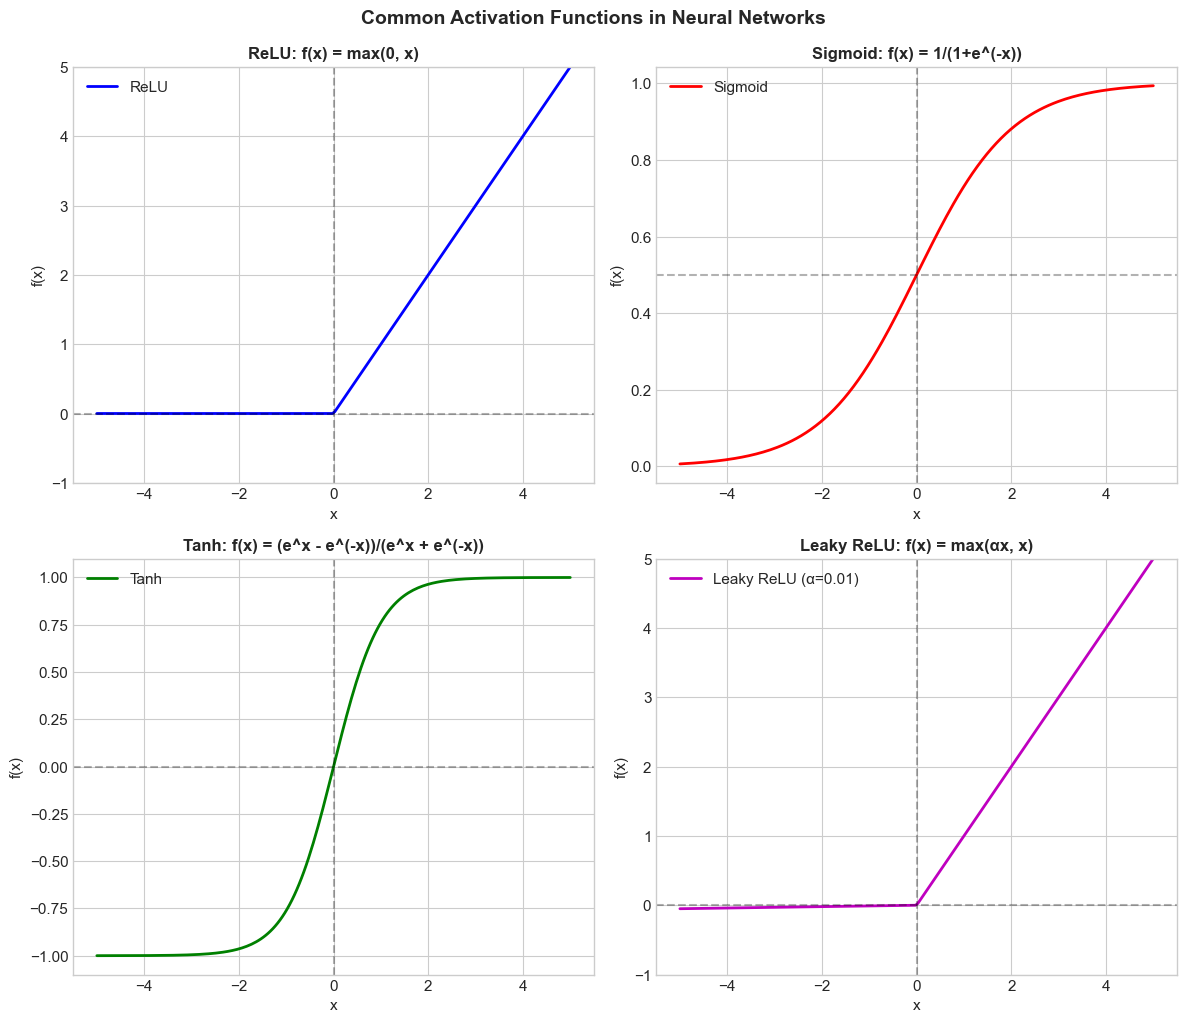

In [2]:
# Visualize Activation Functions
x = np.linspace(-5, 5, 200)

# Define activation functions
def relu(x):
    return np.maximum(0, x)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def tanh(x):
    return np.tanh(x)

def leaky_relu(x, alpha=0.01):
    return np.where(x > 0, x, alpha * x)

# Plot
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# ReLU
axes[0, 0].plot(x, relu(x), 'b-', linewidth=2, label='ReLU')
axes[0, 0].axhline(y=0, color='k', linestyle='--', alpha=0.3)
axes[0, 0].axvline(x=0, color='k', linestyle='--', alpha=0.3)
axes[0, 0].set_title('ReLU: f(x) = max(0, x)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('x')
axes[0, 0].set_ylabel('f(x)')
axes[0, 0].legend()
axes[0, 0].set_ylim(-1, 5)

# Sigmoid
axes[0, 1].plot(x, sigmoid(x), 'r-', linewidth=2, label='Sigmoid')
axes[0, 1].axhline(y=0.5, color='k', linestyle='--', alpha=0.3)
axes[0, 1].axvline(x=0, color='k', linestyle='--', alpha=0.3)
axes[0, 1].set_title('Sigmoid: f(x) = 1/(1+e^(-x))', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('x')
axes[0, 1].set_ylabel('f(x)')
axes[0, 1].legend()

# Tanh
axes[1, 0].plot(x, tanh(x), 'g-', linewidth=2, label='Tanh')
axes[1, 0].axhline(y=0, color='k', linestyle='--', alpha=0.3)
axes[1, 0].axvline(x=0, color='k', linestyle='--', alpha=0.3)
axes[1, 0].set_title('Tanh: f(x) = (e^x - e^(-x))/(e^x + e^(-x))', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('x')
axes[1, 0].set_ylabel('f(x)')
axes[1, 0].legend()

# Leaky ReLU
axes[1, 1].plot(x, leaky_relu(x), 'm-', linewidth=2, label='Leaky ReLU (α=0.01)')
axes[1, 1].axhline(y=0, color='k', linestyle='--', alpha=0.3)
axes[1, 1].axvline(x=0, color='k', linestyle='--', alpha=0.3)
axes[1, 1].set_title('Leaky ReLU: f(x) = max(αx, x)', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('x')
axes[1, 1].set_ylabel('f(x)')
axes[1, 1].legend()
axes[1, 1].set_ylim(-1, 5)

plt.tight_layout()
plt.suptitle('Common Activation Functions in Neural Networks', y=1.02, fontsize=14, fontweight='bold')
plt.show()

### 2.4 Simple Perceptron Implementation from Scratch

Before using PyTorch, let's understand how a single perceptron works by implementing it manually:

In [3]:
class SimplePerceptron:
    """
    A simple perceptron implementation for educational purposes.
    In production, you'd use PyTorch's nn.Linear layer.
    """
    def __init__(self, n_features):
        # Initialize weights randomly (Xavier initialization)
        self.weights = np.random.randn(n_features) * np.sqrt(2.0 / n_features)
        self.bias = 0.0
        
    def forward(self, x):
        """Forward pass: compute weighted sum + bias, then apply sigmoid"""
        z = np.dot(x, self.weights) + self.bias
        return 1 / (1 + np.exp(-z))  # Sigmoid activation
    
    def predict(self, x, threshold=0.5):
        """Binary prediction based on threshold"""
        return (self.forward(x) >= threshold).astype(int)

# Example: Simple perceptron for trading signal
# Features: [momentum_5d, volatility_10d, volume_ratio]
perceptron = SimplePerceptron(n_features=3)

# Sample input (normalized features)
sample_features = np.array([0.5, -0.3, 1.2])  # Positive momentum, low vol, high volume
output = perceptron.forward(sample_features)
print(f"Perceptron Output (probability): {output:.4f}")
print(f"Trading Signal: {'LONG' if output >= 0.5 else 'SHORT/FLAT'}")

Perceptron Output (probability): 0.7050
Trading Signal: LONG


## 3. Data Loading

We'll load SPY (S&P 500 ETF) data as our primary dataset. For European market practitioners:

- **EURO STOXX 50**: Ticker `^STOXX50E` (top 50 Eurozone stocks)
- **DAX**: Ticker `^GDAXI` (German blue chips)
- **CAC 40**: Ticker `^FCHI` (French blue chips)
- **FTSE 100**: Ticker `^FTSE` (UK market)

The techniques here apply directly to these indices.

In [4]:
# Download SPY data (5 years of daily data)
ticker = "SPY"
start_date = "2019-01-01"
end_date = "2024-12-31"

print(f"Downloading {ticker} data from {start_date} to {end_date}...")
data = yf.download(ticker, start=start_date, end=end_date, progress=False)

# yfinance with auto_adjust=True (default) uses 'Close' not 'Adj Close'
print(f"\nData Shape: {data.shape}")
print(f"Date Range: {data.index[0].strftime('%Y-%m-%d')} to {data.index[-1].strftime('%Y-%m-%d')}")
print(f"\nColumns: {data.columns.tolist()}")
data.head()


Data Shape: (1509, 5)
Date Range: 2019-01-02 to 2024-12-30

Columns: [('Close', 'SPY'), ('High', 'SPY'), ('Low', 'SPY'), ('Open', 'SPY'), ('Volume', 'SPY')]


Price,Close,High,Low,Open,Volume
Ticker,SPY,SPY,SPY,SPY,SPY
Date,,,,,
2019-01-02,224.995316,225.921642,221.191138,221.218116,126925200
2019-01-03,219.626297,223.547393,219.140649,223.241609,144140700
2019-01-04,226.982849,227.630371,222.288326,222.666044,142628800
2019-01-07,228.772507,230.184453,226.353297,227.252631,103139100
2019-01-08,230.921951,231.407599,228.430806,230.966934,102512600


In [5]:
# Handle MultiIndex columns if present (yfinance returns MultiIndex for single ticker)
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.get_level_values(0)

# Calculate returns
data['Returns'] = data['Close'].pct_change()
data['Log_Returns'] = np.log(data['Close'] / data['Close'].shift(1))

# Forward returns (what we want to predict)
data['Forward_Return'] = data['Returns'].shift(-1)

# Binary target: 1 if positive return, 0 otherwise
data['Target'] = (data['Forward_Return'] > 0).astype(int)

print("Returns Statistics:")
print(data['Returns'].describe())
print(f"\nTarget Distribution (next day up/down):")
print(data['Target'].value_counts(normalize=True))

Returns Statistics:
count    1508.000000
mean        0.000708
std         0.012499
min        -0.109424
25%        -0.004396
50%         0.000909
75%         0.006906
max         0.090603
Name: Returns, dtype: float64

Target Distribution (next day up/down):
Target
1    0.555335
0    0.444665
Name: proportion, dtype: float64


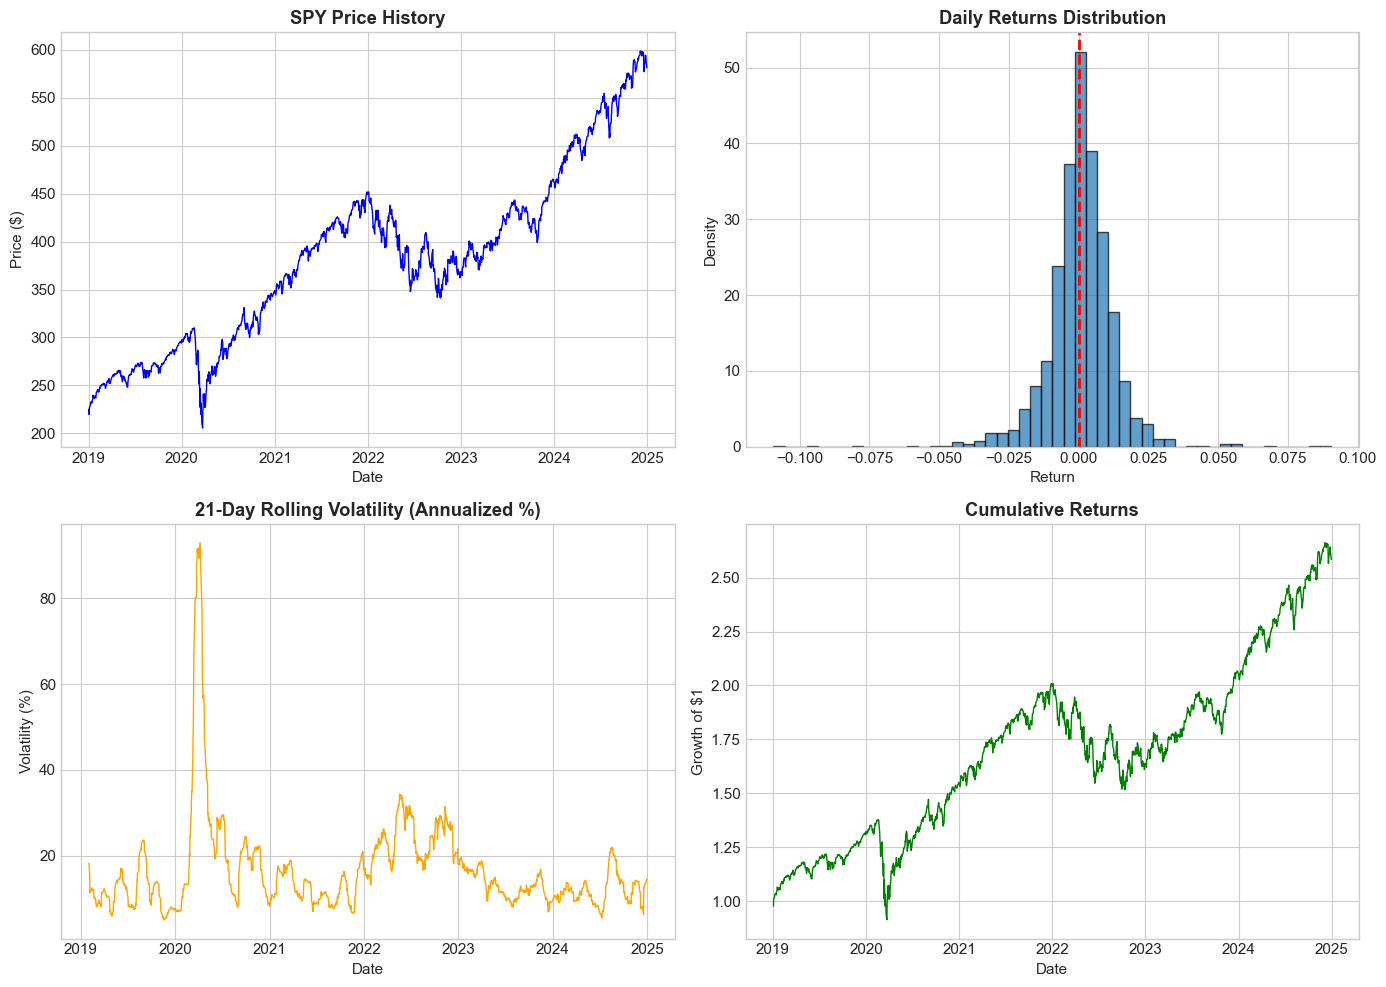

In [6]:
# Visualize the price series and returns distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Price chart
axes[0, 0].plot(data.index, data['Close'], 'b-', linewidth=1)
axes[0, 0].set_title(f'{ticker} Price History', fontweight='bold')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Price ($)')

# Returns distribution
axes[0, 1].hist(data['Returns'].dropna(), bins=50, edgecolor='black', alpha=0.7, density=True)
axes[0, 1].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[0, 1].set_title('Daily Returns Distribution', fontweight='bold')
axes[0, 1].set_xlabel('Return')
axes[0, 1].set_ylabel('Density')

# Rolling volatility
rolling_vol = data['Returns'].rolling(window=21).std() * np.sqrt(252) * 100
axes[1, 0].plot(data.index, rolling_vol, 'orange', linewidth=1)
axes[1, 0].set_title('21-Day Rolling Volatility (Annualized %)', fontweight='bold')
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Volatility (%)')

# Cumulative returns
cumulative_returns = (1 + data['Returns']).cumprod()
axes[1, 1].plot(data.index, cumulative_returns, 'g-', linewidth=1)
axes[1, 1].set_title('Cumulative Returns', fontweight='bold')
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('Growth of $1')

plt.tight_layout()
plt.show()

## 4. Feature Engineering

Creating meaningful features is crucial for neural network performance. We'll engineer features commonly used in systematic trading:

### Feature Categories:
1. **Momentum Features**: Capture trend strength and direction
2. **Volatility Features**: Market risk and regime indicators
3. **Volume Features**: Trading activity and liquidity signals
4. **Technical Indicators**: RSI-like, moving average crossovers

**European Market Note**: For European equities, consider adding:
- EUR/USD exchange rate changes (for non-EUR stocks)
- ECB announcement proximity indicators
- Cross-market correlations (DAX-CAC spread)

In [7]:
def create_features(df):
    """
    Create technical features for neural network input.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame with OHLCV data
    
    Returns:
    --------
    df : pd.DataFrame
        DataFrame with additional features
    """
    df = df.copy()
    
    # ========== MOMENTUM FEATURES ==========
    # Returns over different lookback periods
    for period in [1, 5, 10, 21]:
        df[f'Return_{period}d'] = df['Close'].pct_change(period)
    
    # Moving average ratios (price relative to MA)
    for period in [5, 10, 20, 50]:
        df[f'MA_{period}'] = df['Close'].rolling(window=period).mean()
        df[f'Price_MA_{period}_Ratio'] = df['Close'] / df[f'MA_{period}']
    
    # MA crossover signals
    df['MA_5_20_Cross'] = df['MA_5'] / df['MA_20']
    
    # ========== VOLATILITY FEATURES ==========
    # Historical volatility
    for period in [5, 10, 21]:
        df[f'Volatility_{period}d'] = df['Returns'].rolling(window=period).std()
    
    # Volatility ratio (short-term vs long-term)
    df['Vol_Ratio_5_21'] = df['Volatility_5d'] / df['Volatility_21d']
    
    # High-Low range (intraday volatility proxy)
    df['HL_Range'] = (df['High'] - df['Low']) / df['Close']
    df['HL_Range_MA5'] = df['HL_Range'].rolling(window=5).mean()
    
    # ========== RSI-LIKE INDICATOR ==========
    def compute_rsi(series, period=14):
        delta = series.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
        rs = gain / loss
        return 100 - (100 / (1 + rs))
    
    df['RSI_14'] = compute_rsi(df['Close'], period=14)
    df['RSI_Normalized'] = (df['RSI_14'] - 50) / 50  # Normalize to [-1, 1]
    
    # ========== VOLUME FEATURES ==========
    df['Volume_MA_10'] = df['Volume'].rolling(window=10).mean()
    df['Volume_Ratio'] = df['Volume'] / df['Volume_MA_10']
    
    # Volume-price relationship
    df['Volume_Return_Corr_10d'] = df['Returns'].rolling(window=10).corr(df['Volume'].pct_change())
    
    # ========== MEAN REVERSION FEATURES ==========
    # Distance from recent high/low (useful for mean reversion)
    df['Dist_from_20d_High'] = df['Close'] / df['High'].rolling(window=20).max() - 1
    df['Dist_from_20d_Low'] = df['Close'] / df['Low'].rolling(window=20).min() - 1
    
    # Z-score of returns (mean reversion signal)
    df['Return_Zscore_21d'] = (df['Returns'] - df['Returns'].rolling(21).mean()) / df['Returns'].rolling(21).std()
    
    return df

# Apply feature engineering
data = create_features(data)
print(f"Total features created: {len(data.columns)}")
print(f"\nNew columns:")
print(data.columns.tolist())

Total features created: 36

New columns:
['Close', 'High', 'Low', 'Open', 'Volume', 'Returns', 'Log_Returns', 'Forward_Return', 'Target', 'Return_1d', 'Return_5d', 'Return_10d', 'Return_21d', 'MA_5', 'Price_MA_5_Ratio', 'MA_10', 'Price_MA_10_Ratio', 'MA_20', 'Price_MA_20_Ratio', 'MA_50', 'Price_MA_50_Ratio', 'MA_5_20_Cross', 'Volatility_5d', 'Volatility_10d', 'Volatility_21d', 'Vol_Ratio_5_21', 'HL_Range', 'HL_Range_MA5', 'RSI_14', 'RSI_Normalized', 'Volume_MA_10', 'Volume_Ratio', 'Volume_Return_Corr_10d', 'Dist_from_20d_High', 'Dist_from_20d_Low', 'Return_Zscore_21d']


In [8]:
# Select features for the model (exclude price levels, keep ratios and normalized values)
feature_columns = [
    # Momentum
    'Return_1d', 'Return_5d', 'Return_10d', 'Return_21d',
    'Price_MA_5_Ratio', 'Price_MA_10_Ratio', 'Price_MA_20_Ratio', 'Price_MA_50_Ratio',
    'MA_5_20_Cross',
    # Volatility
    'Volatility_5d', 'Volatility_10d', 'Volatility_21d',
    'Vol_Ratio_5_21', 'HL_Range', 'HL_Range_MA5',
    # Technical
    'RSI_Normalized',
    # Volume
    'Volume_Ratio',
    # Mean reversion
    'Dist_from_20d_High', 'Dist_from_20d_Low', 'Return_Zscore_21d'
]

print(f"Selected {len(feature_columns)} features for modeling")
print("\nFeatures:")
for i, col in enumerate(feature_columns, 1):
    print(f"  {i}. {col}")

Selected 20 features for modeling

Features:
  1. Return_1d
  2. Return_5d
  3. Return_10d
  4. Return_21d
  5. Price_MA_5_Ratio
  6. Price_MA_10_Ratio
  7. Price_MA_20_Ratio
  8. Price_MA_50_Ratio
  9. MA_5_20_Cross
  10. Volatility_5d
  11. Volatility_10d
  12. Volatility_21d
  13. Vol_Ratio_5_21
  14. HL_Range
  15. HL_Range_MA5
  16. RSI_Normalized
  17. Volume_Ratio
  18. Dist_from_20d_High
  19. Dist_from_20d_Low
  20. Return_Zscore_21d


Dataset size after removing NaN: 1459 samples
Date range: 2019-03-14 to 2024-12-27


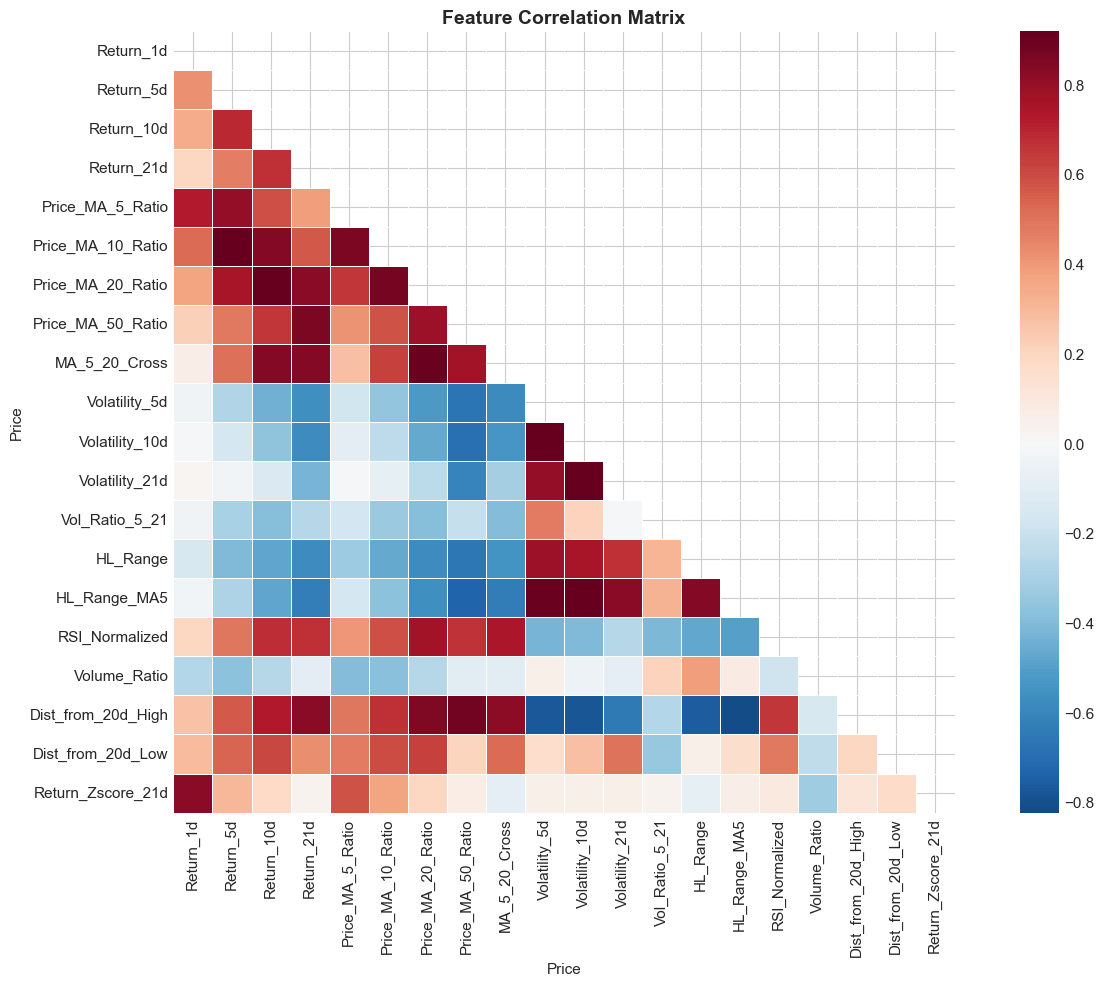

In [9]:
# Prepare final dataset (drop NaN rows caused by rolling calculations)
model_data = data[feature_columns + ['Target', 'Forward_Return']].dropna()
print(f"Dataset size after removing NaN: {len(model_data)} samples")
print(f"Date range: {model_data.index[0].strftime('%Y-%m-%d')} to {model_data.index[-1].strftime('%Y-%m-%d')}")

# Feature correlation heatmap
plt.figure(figsize=(14, 10))
corr_matrix = model_data[feature_columns].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='RdBu_r', center=0,
            square=True, linewidths=0.5)
plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 5. Data Preparation for PyTorch

Key considerations for time series data:

1. **No random shuffling**: We must respect temporal order
2. **Walk-forward split**: Train on past, test on future (mimics real trading)
3. **Standardization**: Scale features using only training data statistics

**Important**: Never use future information when scaling (data leakage)!

In [10]:
# Time-based train/test split (80% train, 20% test)
split_idx = int(len(model_data) * 0.8)

train_data = model_data.iloc[:split_idx]
test_data = model_data.iloc[split_idx:]

print(f"Training set: {len(train_data)} samples ({train_data.index[0].strftime('%Y-%m-%d')} to {train_data.index[-1].strftime('%Y-%m-%d')})")
print(f"Test set: {len(test_data)} samples ({test_data.index[0].strftime('%Y-%m-%d')} to {test_data.index[-1].strftime('%Y-%m-%d')})")

# Separate features and target
X_train = train_data[feature_columns].values
y_train = train_data['Target'].values
X_test = test_data[feature_columns].values
y_test = test_data['Target'].values

# Store forward returns for backtesting
test_forward_returns = test_data['Forward_Return'].values

Training set: 1167 samples (2019-03-14 to 2023-10-30)
Test set: 292 samples (2023-10-31 to 2024-12-27)


In [11]:
# Standardize features (fit only on training data!)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # Transform using train statistics

# Handle any remaining NaN/Inf values
X_train_scaled = np.nan_to_num(X_train_scaled, nan=0.0, posinf=0.0, neginf=0.0)
X_test_scaled = np.nan_to_num(X_test_scaled, nan=0.0, posinf=0.0, neginf=0.0)

print("Feature scaling statistics (from training set):")
print(f"Means: min={scaler.mean_.min():.4f}, max={scaler.mean_.max():.4f}")
print(f"Stds: min={scaler.scale_.min():.4f}, max={scaler.scale_.max():.4f}")

Feature scaling statistics (from training set):
Means: min=-0.0389, max=1.0116
Stds: min=0.0077, max=0.9966


In [12]:
# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train).unsqueeze(1)  # Shape: (N, 1)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test).unsqueeze(1)

# Create DataLoader for batch training
batch_size = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # Shuffle within training set is OK

print(f"Training batches: {len(train_loader)}")
print(f"Batch size: {batch_size}")
print(f"Input dimension: {X_train_tensor.shape[1]}")

Training batches: 19
Batch size: 64
Input dimension: 20


## 6. Multi-Layer Perceptron (MLP) Implementation

We'll build a feedforward neural network with:
- Input layer matching our feature count
- Two hidden layers with ReLU activation
- Dropout for regularization
- Batch normalization for stable training
- Output layer with sigmoid for probability

### Architecture:
```
Input (20) → Dense (64) → ReLU → Dropout → BatchNorm
           → Dense (32) → ReLU → Dropout → BatchNorm  
           → Dense (1) → Sigmoid → Output
```

In [13]:
class TradingMLP(nn.Module):
    """
    Multi-Layer Perceptron for return direction prediction.
    
    Architecture designed for:
    - Tabular financial data
    - Binary classification (up/down prediction)
    - Regularization to prevent overfitting to noise
    """
    
    def __init__(self, input_dim, hidden_dims=[64, 32], dropout_rate=0.3):
        super(TradingMLP, self).__init__()
        
        # Build layers dynamically
        layers = []
        prev_dim = input_dim
        
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU(),
                nn.BatchNorm1d(hidden_dim),
                nn.Dropout(dropout_rate)
            ])
            prev_dim = hidden_dim
        
        # Output layer
        layers.append(nn.Linear(prev_dim, 1))
        layers.append(nn.Sigmoid())
        
        self.network = nn.Sequential(*layers)
        
        # Initialize weights (Xavier/Glorot initialization)
        self._init_weights()
    
    def _init_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                nn.init.constant_(module.bias, 0)
    
    def forward(self, x):
        return self.network(x)

# Initialize model
input_dim = X_train_tensor.shape[1]
model = TradingMLP(input_dim=input_dim, hidden_dims=[64, 32], dropout_rate=0.3)
model = model.to(device)

print("Model Architecture:")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

Model Architecture:
TradingMLP(
  (network): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=32, out_features=1, bias=True)
    (9): Sigmoid()
  )
)

Total parameters: 3,649
Trainable parameters: 3,649


## 7. Training Loop

Training components:
- **Loss Function**: Binary Cross-Entropy (standard for binary classification)
- **Optimizer**: Adam with learning rate scheduling
- **Early Stopping**: Prevent overfitting by monitoring validation loss

**Quant Note**: In production, you'd also track:
- Prediction accuracy by market regime
- Feature importance stability
- P&L during training validation

In [15]:
# Training configuration
learning_rate = 0.001
num_epochs = 100
patience = 15  # Early stopping patience

# Loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

# Learning rate scheduler (reduce LR when loss plateaus)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

print(f"Training Configuration:")
print(f"  - Learning Rate: {learning_rate}")
print(f"  - Epochs: {num_epochs}")
print(f"  - Batch Size: {batch_size}")
print(f"  - Early Stopping Patience: {patience}")

Training Configuration:
  - Learning Rate: 0.001
  - Epochs: 100
  - Batch Size: 64
  - Early Stopping Patience: 15


In [16]:
def train_model(model, train_loader, X_val, y_val, criterion, optimizer, scheduler, 
                num_epochs, patience, device):
    """
    Training loop with early stopping and validation monitoring.
    """
    train_losses = []
    val_losses = []
    val_accuracies = []
    
    best_val_loss = float('inf')
    best_model_state = None
    epochs_without_improvement = 0
    
    X_val = X_val.to(device)
    y_val = y_val.to(device)
    
    for epoch in range(num_epochs):
        # ========== TRAINING ==========
        model.train()
        epoch_loss = 0.0
        
        for batch_X, batch_y in train_loader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)
            
            # Forward pass
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            
            # Gradient clipping (prevents exploding gradients)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            epoch_loss += loss.item()
        
        avg_train_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # ========== VALIDATION ==========
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val).item()
            val_preds = (val_outputs >= 0.5).float()
            val_accuracy = (val_preds == y_val).float().mean().item()
        
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        # Learning rate scheduling
        scheduler.step(val_loss)
        
        # ========== EARLY STOPPING ==========
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
        
        # Print progress every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] | "
                  f"Train Loss: {avg_train_loss:.4f} | "
                  f"Val Loss: {val_loss:.4f} | "
                  f"Val Acc: {val_accuracy:.4f}")
        
        # Early stopping check
        if epochs_without_improvement >= patience:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"Loaded best model with validation loss: {best_val_loss:.4f}")
    
    return train_losses, val_losses, val_accuracies

# Train the model
print("Starting training...\n")
train_losses, val_losses, val_accuracies = train_model(
    model, train_loader, X_test_tensor, y_test_tensor,
    criterion, optimizer, scheduler, num_epochs, patience, device
)

Starting training...

Epoch [10/100] | Train Loss: 0.7172 | Val Loss: 0.6770 | Val Acc: 0.5479
Epoch [20/100] | Train Loss: 0.6995 | Val Loss: 0.6783 | Val Acc: 0.5753

Early stopping at epoch 24
Loaded best model with validation loss: 0.6751


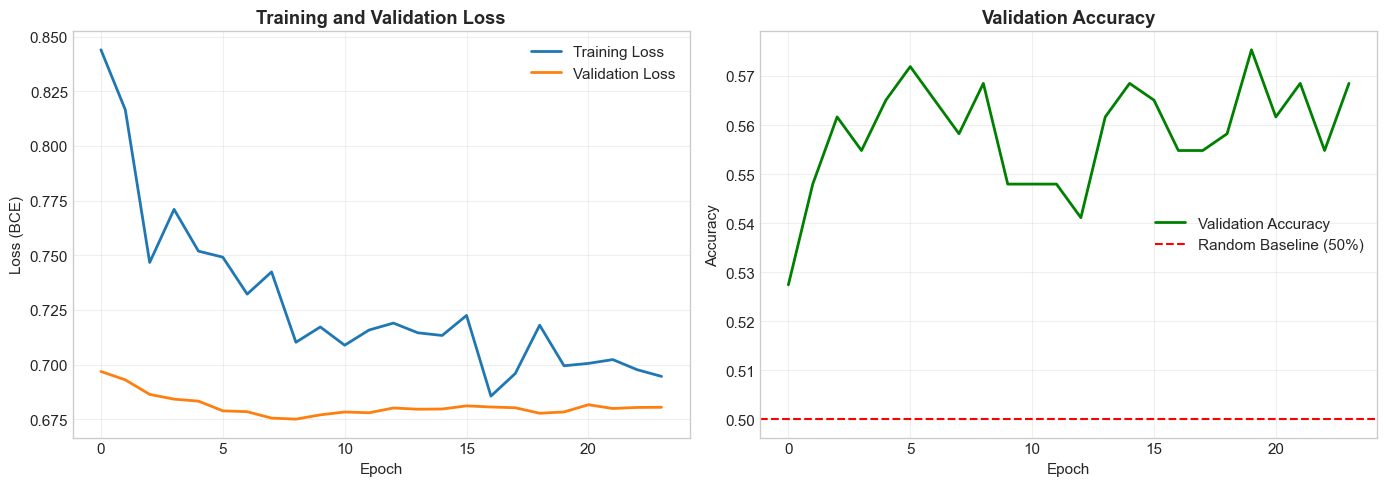

In [17]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss curves
axes[0].plot(train_losses, label='Training Loss', linewidth=2)
axes[0].plot(val_losses, label='Validation Loss', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (BCE)')
axes[0].set_title('Training and Validation Loss', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy curve
axes[1].plot(val_accuracies, label='Validation Accuracy', color='green', linewidth=2)
axes[1].axhline(y=0.5, color='r', linestyle='--', label='Random Baseline (50%)')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Validation Accuracy', fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Backtesting Strategy

Convert model predictions to trading signals and evaluate performance:

**Strategy Logic**:
- Prediction > 0.5 → Long position (expect price to rise)
- Prediction ≤ 0.5 → Flat/Cash position (expect price to fall)

**European Market Considerations**:
- Transaction costs: ~5-10 bps for European equities
- Market impact: Lower liquidity in smaller European markets
- Settlement: T+2 for most European markets

Prediction Distribution:
  Long signals: 250 (85.6%)
  Flat signals: 42 (14.4%)


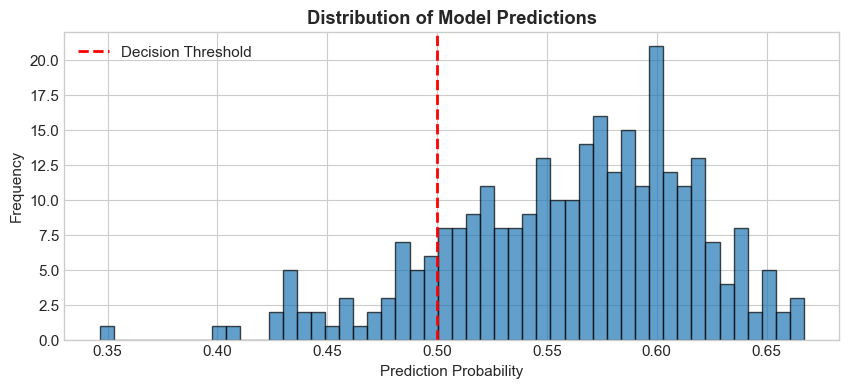

In [18]:
# Generate predictions on test set
model.eval()
with torch.no_grad():
    X_test_device = X_test_tensor.to(device)
    predictions_prob = model(X_test_device).cpu().numpy().flatten()

# Convert to trading signals
# 1 = Long, 0 = Flat (no short selling for simplicity)
signals = (predictions_prob >= 0.5).astype(int)

print("Prediction Distribution:")
print(f"  Long signals: {signals.sum()} ({signals.mean()*100:.1f}%)")
print(f"  Flat signals: {len(signals) - signals.sum()} ({(1-signals.mean())*100:.1f}%)")

# Display prediction confidence distribution
plt.figure(figsize=(10, 4))
plt.hist(predictions_prob, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(x=0.5, color='r', linestyle='--', linewidth=2, label='Decision Threshold')
plt.xlabel('Prediction Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Model Predictions', fontweight='bold')
plt.legend()
plt.show()

In [19]:
# Calculate strategy returns
# Note: Forward returns are the returns we're trying to predict
# Our position today is based on today's prediction for tomorrow's return

# Create backtest DataFrame
backtest_df = pd.DataFrame({
    'Date': test_data.index[:-1],  # Remove last row (no forward return)
    'Forward_Return': test_forward_returns[:-1],
    'Prediction_Prob': predictions_prob[:-1],
    'Signal': signals[:-1]
}).set_index('Date')

# Strategy return = Signal * Forward_Return
# If long (signal=1), we earn the forward return
# If flat (signal=0), we earn 0
backtest_df['Strategy_Return'] = backtest_df['Signal'] * backtest_df['Forward_Return']

# Buy & Hold return (always long)
backtest_df['BuyHold_Return'] = backtest_df['Forward_Return']

# Transaction costs (apply when signal changes)
transaction_cost = 0.001  # 10 bps per trade (round trip)
backtest_df['Signal_Change'] = backtest_df['Signal'].diff().abs()
backtest_df['Transaction_Cost'] = backtest_df['Signal_Change'] * transaction_cost
backtest_df['Strategy_Return_Net'] = backtest_df['Strategy_Return'] - backtest_df['Transaction_Cost']

# Cumulative returns
backtest_df['Cum_Strategy'] = (1 + backtest_df['Strategy_Return_Net']).cumprod()
backtest_df['Cum_BuyHold'] = (1 + backtest_df['BuyHold_Return']).cumprod()

print("Backtest DataFrame:")
backtest_df.head(10)

Backtest DataFrame:


,Forward_Return,Prediction_Prob,Signal,Strategy_Return,BuyHold_Return,Signal_Change,Transaction_Cost,Strategy_Return_Net,Cum_Strategy,Cum_BuyHold
Date,,,,,,,,,,
2023-10-31,0.010665,0.438427,0,0.000000,0.010665,NaN,NaN,NaN,NaN,1.010665
2023-11-01,0.019164,0.482932,0,0.000000,0.019164,0.0,0.000,0.000000,1.000000,1.030033
2023-11-02,0.009123,0.499452,0,0.000000,0.009123,0.0,0.000,0.000000,1.000000,1.039431
2023-11-03,0.002300,0.485362,0,0.000000,0.002300,0.0,0.000,0.000000,1.000000,1.041822
2023-11-06,0.002846,0.572480,1,0.002846,0.002846,1.0,0.001,0.001846,1.001846,1.044787
2023-11-07,0.000732,0.562888,1,0.000732,0.000732,0.0,0.000,0.000732,1.002580,1.045552
2023-11-08,-0.007799,0.508367,1,-0.007799,-0.007799,0.0,0.000,-0.007799,0.994761,1.037398
2023-11-09,0.015605,0.482596,0,0.000000,0.015605,1.0,0.001,-0.001000,0.993766,1.053587
2023-11-10,-0.000953,0.497953,0,-0.000000,-0.000953,0.0,0.000,-0.000000,0.993766,1.052583


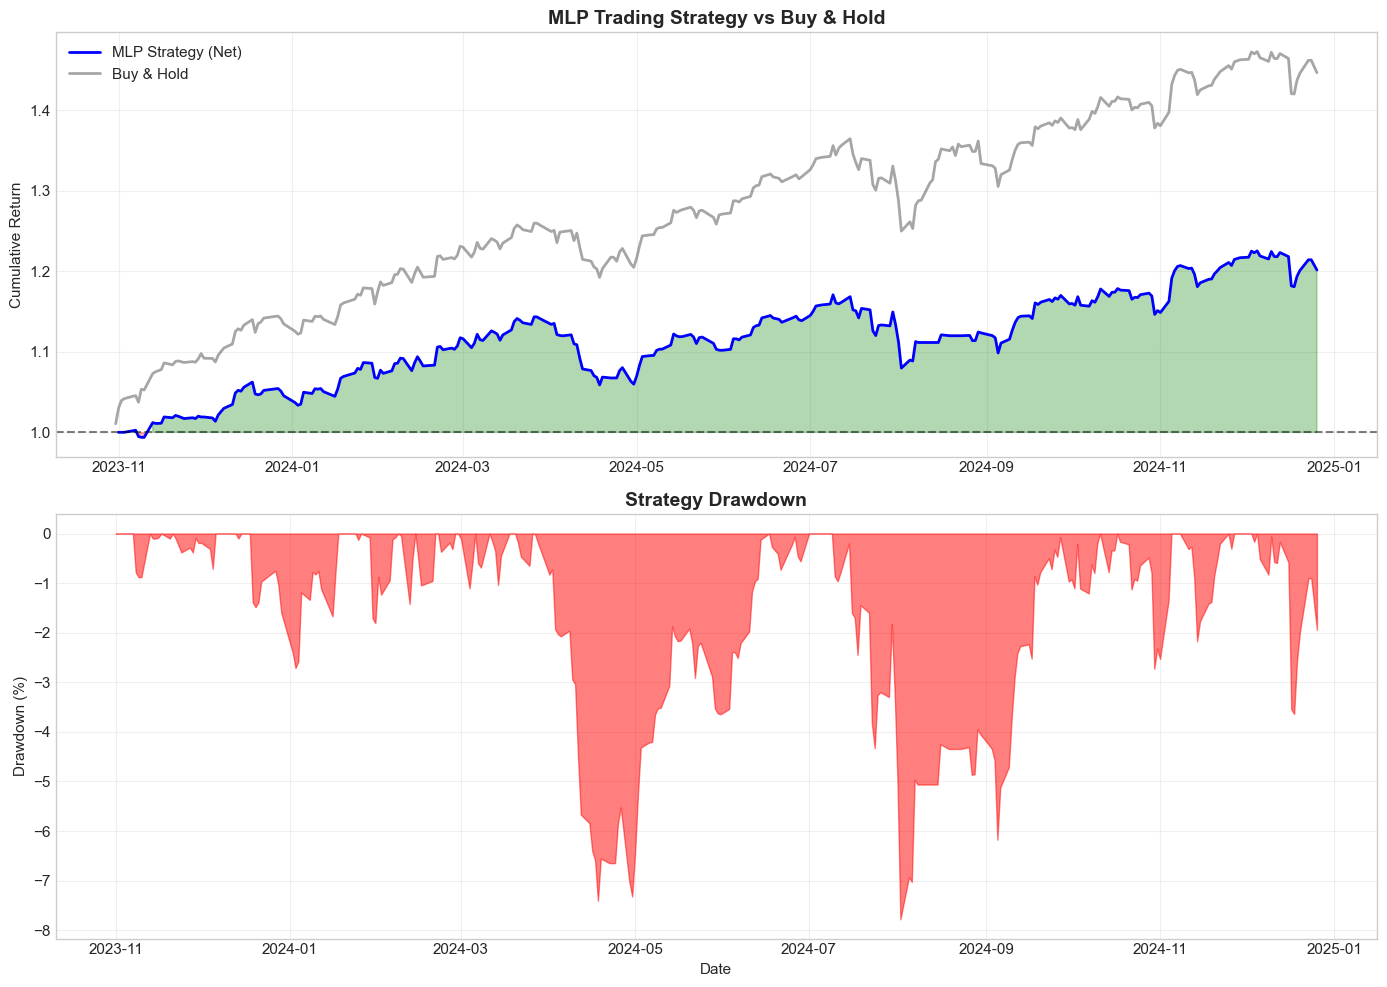

In [20]:
# Plot cumulative returns
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Cumulative returns comparison
axes[0].plot(backtest_df.index, backtest_df['Cum_Strategy'], 
             label='MLP Strategy (Net)', linewidth=2, color='blue')
axes[0].plot(backtest_df.index, backtest_df['Cum_BuyHold'], 
             label='Buy & Hold', linewidth=2, color='gray', alpha=0.7)
axes[0].fill_between(backtest_df.index, 1, backtest_df['Cum_Strategy'], 
                     where=backtest_df['Cum_Strategy'] >= 1, alpha=0.3, color='green')
axes[0].fill_between(backtest_df.index, 1, backtest_df['Cum_Strategy'], 
                     where=backtest_df['Cum_Strategy'] < 1, alpha=0.3, color='red')
axes[0].axhline(y=1, color='black', linestyle='--', alpha=0.5)
axes[0].set_ylabel('Cumulative Return')
axes[0].set_title('MLP Trading Strategy vs Buy & Hold', fontsize=14, fontweight='bold')
axes[0].legend(loc='upper left')
axes[0].grid(True, alpha=0.3)

# Drawdown analysis
rolling_max = backtest_df['Cum_Strategy'].expanding().max()
drawdown = (backtest_df['Cum_Strategy'] - rolling_max) / rolling_max * 100

axes[1].fill_between(backtest_df.index, 0, drawdown, color='red', alpha=0.5)
axes[1].set_ylabel('Drawdown (%)')
axes[1].set_xlabel('Date')
axes[1].set_title('Strategy Drawdown', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Performance Metrics

Essential metrics for evaluating trading strategies:

1. **Sharpe Ratio**: Risk-adjusted return (target > 1.0 for institutional quality)
2. **Max Drawdown**: Largest peak-to-trough decline
3. **Win Rate**: Percentage of profitable trades
4. **Profit Factor**: Gross profits / Gross losses
5. **Calmar Ratio**: Annual return / Max drawdown

In [21]:
def calculate_performance_metrics(returns, risk_free_rate=0.02):
    """
    Calculate comprehensive performance metrics for a trading strategy.
    
    Parameters:
    -----------
    returns : pd.Series
        Daily returns of the strategy
    risk_free_rate : float
        Annual risk-free rate (default: 2% for European context)
    
    Returns:
    --------
    dict : Performance metrics
    """
    # Remove NaN values
    returns = returns.dropna()
    
    # Basic statistics
    total_return = (1 + returns).prod() - 1
    annual_return = (1 + total_return) ** (252 / len(returns)) - 1
    annual_volatility = returns.std() * np.sqrt(252)
    
    # Sharpe Ratio
    excess_return = annual_return - risk_free_rate
    sharpe_ratio = excess_return / annual_volatility if annual_volatility > 0 else 0
    
    # Max Drawdown
    cumulative = (1 + returns).cumprod()
    rolling_max = cumulative.expanding().max()
    drawdown = (cumulative - rolling_max) / rolling_max
    max_drawdown = drawdown.min()
    
    # Calmar Ratio
    calmar_ratio = annual_return / abs(max_drawdown) if max_drawdown != 0 else 0
    
    # Win Rate
    winning_days = (returns > 0).sum()
    total_days = len(returns)
    win_rate = winning_days / total_days
    
    # Profit Factor
    gross_profits = returns[returns > 0].sum()
    gross_losses = abs(returns[returns < 0].sum())
    profit_factor = gross_profits / gross_losses if gross_losses > 0 else np.inf
    
    # Sortino Ratio (uses only downside volatility)
    downside_returns = returns[returns < 0]
    downside_vol = downside_returns.std() * np.sqrt(252)
    sortino_ratio = excess_return / downside_vol if downside_vol > 0 else 0
    
    return {
        'Total Return': f"{total_return:.2%}",
        'Annual Return': f"{annual_return:.2%}",
        'Annual Volatility': f"{annual_volatility:.2%}",
        'Sharpe Ratio': f"{sharpe_ratio:.2f}",
        'Sortino Ratio': f"{sortino_ratio:.2f}",
        'Max Drawdown': f"{max_drawdown:.2%}",
        'Calmar Ratio': f"{calmar_ratio:.2f}",
        'Win Rate': f"{win_rate:.2%}",
        'Profit Factor': f"{profit_factor:.2f}"
    }

# Calculate metrics for both strategies
strategy_metrics = calculate_performance_metrics(backtest_df['Strategy_Return_Net'])
buyhold_metrics = calculate_performance_metrics(backtest_df['BuyHold_Return'])

# Display comparison
comparison_df = pd.DataFrame({
    'MLP Strategy': strategy_metrics,
    'Buy & Hold': buyhold_metrics
})

print("="*60)
print("PERFORMANCE COMPARISON")
print("="*60)
print(comparison_df.to_string())
print("="*60)

PERFORMANCE COMPARISON
                  MLP Strategy Buy & Hold
Total Return            20.16%     44.69%
Annual Return           17.31%     37.70%
Annual Volatility       11.28%     12.32%
Sharpe Ratio              1.36       2.90
Sortino Ratio             1.68       3.80
Max Drawdown            -7.78%     -8.41%
Calmar Ratio              2.22       4.49
Win Rate                51.38%     61.17%
Profit Factor             1.31       1.58


In [ ]:
# Classification metrics (model accuracy)
actual_direction = (backtest_df['Forward_Return'] > 0).astype(int).values
predicted_direction = backtest_df['Signal'].values

print("\n" + "="*60)
print("MODEL CLASSIFICATION METRICS")
print("="*60)
print(f"\nAccuracy: {accuracy_score(actual_direction, predicted_direction):.4f}")
print("\nClassification Report:")
print(classification_report(actual_direction, predicted_direction, 
                          target_names=['Down Day', 'Up Day']))

In [ ]:
# Monthly returns heatmap
monthly_returns = backtest_df['Strategy_Return_Net'].resample('ME').apply(
    lambda x: (1 + x).prod() - 1
) * 100  # Convert to percentage

# Create pivot table for heatmap
monthly_returns_df = pd.DataFrame({
    'Year': monthly_returns.index.year,
    'Month': monthly_returns.index.month,
    'Return': monthly_returns.values
})

pivot_returns = monthly_returns_df.pivot(index='Year', columns='Month', values='Return')
pivot_returns.columns = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                         'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'][:len(pivot_returns.columns)]

plt.figure(figsize=(14, 5))
sns.heatmap(pivot_returns, annot=True, fmt='.1f', center=0, 
            cmap='RdYlGn', linewidths=0.5, cbar_kws={'label': 'Return (%)'})
plt.title('Monthly Strategy Returns (%)', fontsize=14, fontweight='bold')
plt.xlabel('Month')
plt.ylabel('Year')
plt.tight_layout()
plt.show()

## 10. Summary & Key Takeaways

### What We Learned Today

1. **Neural Network Fundamentals**
   - Perceptrons as building blocks
   - Activation functions (ReLU, Sigmoid, Tanh) and their trade-offs
   - Forward propagation mechanics

2. **MLP Architecture for Trading**
   - Input normalization is critical
   - Dropout and BatchNorm for regularization
   - Xavier initialization for stable training

3. **Feature Engineering**
   - Momentum, volatility, and volume features
   - Normalized features work better than raw prices
   - Feature correlation analysis to avoid redundancy

4. **Training Best Practices**
   - Time-based train/test split (never shuffle time series)
   - Early stopping to prevent overfitting
   - Learning rate scheduling

5. **Backtesting & Evaluation**
   - Transaction costs matter!
   - Multiple metrics needed (Sharpe, Drawdown, Win Rate)
   - Compare against benchmarks

---

### Real-World Applications at Quant Firms

| Firm | Application | Notes |
|------|-------------|-------|
| **Two Sigma** | Alpha signal generation | Ensemble of NNs with traditional factors |
| **Citadel** | Options pricing & hedging | Deep learning for volatility surfaces |
| **DE Shaw** | Market microstructure | HFT signal generation |
| **Man AHL** | Trend following | NN-enhanced CTA strategies |
| **WorldQuant** | Alpha research | Automated feature discovery |

**European Context**:
- **GSA Capital** (London): ML-driven systematic trading
- **Winton Group** (London): Scientific approach to investment
- **CFM** (Paris): Pioneer in ML for finance

---

### Important Caveats

⚠️ **This is educational material. In production:**

1. **Overfitting Risk**: Financial data is noisy; out-of-sample performance often disappoints
2. **Transaction Costs**: Real costs (spread, slippage, fees) are higher than modeled
3. **Market Regimes**: Models trained in bull markets fail in bear markets
4. **Data Quality**: Production systems need robust data pipelines
5. **Regulatory Compliance**: MiFID II (Europe), SEC regulations (US)

---

### Next Steps

📚 **Day 2**: Convolutional Neural Networks for price pattern recognition  
📚 **Day 3**: Regularization techniques (L1, L2, Dropout in depth)  
📚 **Day 4**: Hyperparameter tuning with Optuna  
📚 **Day 5**: Production deployment considerations

---

### Additional Resources

- **Books**: 
  - "Advances in Financial Machine Learning" - Marcos López de Prado
  - "Machine Learning for Asset Managers" - Marcos López de Prado
  - "Deep Learning" - Ian Goodfellow et al.

- **Papers**:
  - "Deep Learning for Finance: A Review" (2020)
  - "Empirical Asset Pricing via Machine Learning" - Gu, Kelly, Xiu (2020)

- **Practice**: Apply this notebook to European indices (DAX, STOXX 50) and compare results!

In [ ]:
# Save the trained model for future use
import os

# Create models directory if it doesn't exist
models_dir = 'saved_models'
os.makedirs(models_dir, exist_ok=True)

# Save model state dict
model_path = os.path.join(models_dir, 'trading_mlp_day01.pth')
torch.save({
    'model_state_dict': model.state_dict(),
    'scaler_mean': scaler.mean_,
    'scaler_scale': scaler.scale_,
    'feature_columns': feature_columns,
    'input_dim': input_dim
}, model_path)

print(f"Model saved to: {model_path}")
print("\n✅ Day 1 Complete! You've built your first neural network trading strategy.")